# Heat Flux Feature Imputation

**Context**: This dataset was prepared for the journal article entitled _"On the prediction of critical heat flux using a physics-informed machine learning-aided framework"_ (doi: 10.1016/j.applthermaleng.2019.114540). The dataset contains processed and compiled records of experimental critical heat flux and boundary conditions used for the work presented in the article.

**Goal**: Through the provided features impute the `x_e_out [-]`.

**Feature Description**:
- Geometry[-]: geometry of the heat source
- Pressure [Mpa]: Pressure inside the boiler
- Length [mm]: the heated length of the heat source
- Dh [mm]: channel heated diameter
- De [mm]: channel equivalent (or hydraulic) diameter
- chf_exp: Experimental critical heat flux [MW/m2]
- mass_flux [kg/m2 s]: In physics and engineering, mass flux is the rate of mass flow
- x_e [-]: loca/exit equilibrium (or thermodynamic) quality

**Resources**:
- [Kaggle Challenge](https://www.kaggle.com/competitions/playground-series-s3e15/overview)
- [Dataset](https://www.kaggle.com/datasets/saurabhshahane/predicting-heat-flux)

In [1]:
# Import Standard Libraries
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import seaborn as sns

import mlflow

from pathlib import Path
from colorama import Style, Fore

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

In [3]:
# Define Colors
black = Style.BRIGHT + Fore.BLACK
magenta = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blue = Style.BRIGHT + Fore.BLUE
reset_colors = Style.RESET_ALL

# Read Data

In [4]:
# Switch flag for Kaggle Cloud
kaggle = False

# Switch flag for including original dataset
include_original_data = True

In [5]:
# Read training data
if kaggle:
    
    # Read data from Kaggle FS
    data = pd.read_csv('/kaggle/input/playground-series-s3e15/data.csv')
    original_data = pd.read_csv('/kaggle/input/originacsv/heat_flux_feature_imputation_original.csv')
    
else:
    
    # Define local data file paths
    data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E15' / 'heat_flux_feature_imputation_data.csv'
    original_data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E15' / 'heat_flux_feature_imputation_original.csv'
   
    data = pd.read_csv(data_file_path, index_col=0)
    original_data = pd.read_csv(original_data_file_path, index_col=0)

In [6]:
data.head()

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31644 entries, 0 to 31643
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   author               26620 non-null  object 
 1   geometry             26144 non-null  object 
 2   pressure [MPa]       27192 non-null  float64
 3   mass_flux [kg/m2-s]  26853 non-null  float64
 4   x_e_out [-]          21229 non-null  float64
 5   D_e [mm]             26156 non-null  float64
 6   D_h [mm]             27055 non-null  float64
 7   length [mm]          26885 non-null  float64
 8   chf_exp [MW/m2]      31644 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.4+ MB


Since there are some null values in the `x_e_out [-]`, the data would be splitted as follow:
- Train Data: entries with `x_e_out [-]` non-null
- Test Data: entries with `x_e_out [-]` null

## Define Train and Test Data

In [8]:
# Define train_data
train_data = data[data['x_e_out [-]'].notnull()]

In [9]:
# Define test_data
test_data = data[data['x_e_out [-]'].isnull()]

# Exploratory Data Analysis (EDA)

In [23]:
# Define dictionary of data to plot
data_to_plot = {'Train': train_data, 
                'Test': test_data, 
                'Original': original_data}

## Shapes Information

In [10]:
# Print shapes information
print(f'{blue}Data Shapes:'
      f'{blue}\n- Train Data     -> {red}{train_data.shape}'
      f'{blue}\n- Original Data  -> {red}{original_data.shape}'
      f'{blue}\n- Test Data      -> {red}{test_data.shape}\n')

Data Shapes:
- Train Data     -> (21229, 9)
- Original Data  -> (1865, 9)
- Test Data      -> (10415, 9)



## Null Values Information

In [11]:
# Print null values information
print(f'{blue}Data Columns with Null Values:'
      f'{blue}\n- Train Data     -> {red}{train_data.isnull().any().sum()}'
      f'{blue}\n- Original Data  -> {red}{original_data.isnull().any().sum()}'
      f'{blue}\n- Test Data      -> {red}{test_data.isnull().any().sum()}\n')

Data Columns with Null Values:
- Train Data     -> 7
- Original Data  -> 0
- Test Data      -> 8



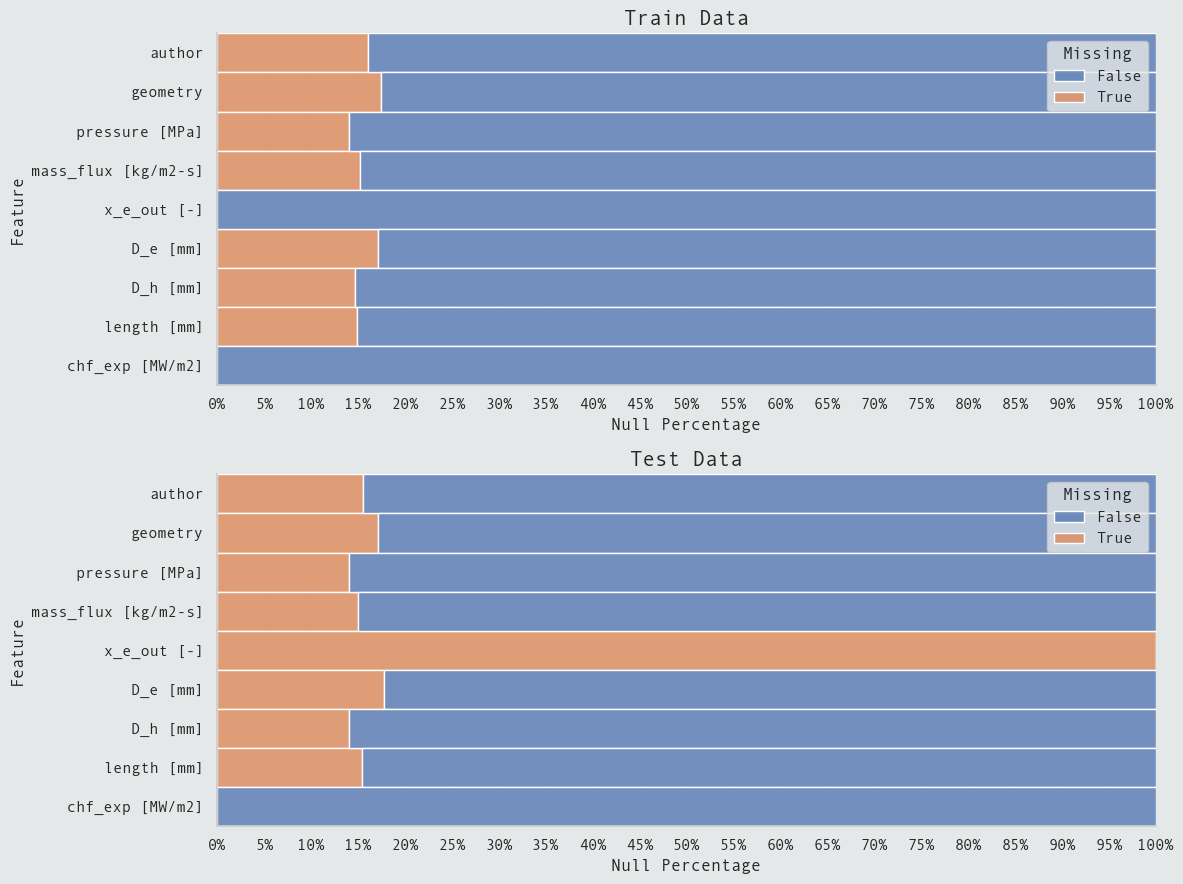

In [12]:
# Define data to display
data_to_display = {
    'Train Data': train_data,
    'Test Data': test_data
}

# Create figure
figure = plt.figure(tight_layout=True, figsize=(12, 9))

# Define figure's subplots
grid_spec = GridSpec(len(data_to_display), 1)

# Fetch data to plot
for row, (name, dataframe) in enumerate(data_to_display.items()):
    
    # Create subplot
    ax = figure.add_subplot(grid_spec[row, 0])
    
    sns.histplot(data=dataframe.isna().melt(var_name='Feature', value_name='Missing'), 
                 y='Feature', 
                 hue='Missing', 
                 multiple='fill',
                 ax=ax)
    
    # Refactor x label as missing percentage
    ax.xaxis.set_major_locator(ticker.LinearLocator(21))
    ax.xaxis.set_major_formatter('{:.0%}'.format)
    
    # Set title and label
    ax.set_title(name, fontsize=15)
    ax.set_xlabel('Null Percentage')

There is quite a huge amount of null values in most of the columns. Around 15% in all the features. Need to come up with a good imputation strategy.

## Feature Distribution

### Numerical Feature Distribution

In [13]:
# Define raw numerical features
raw_numerical_features = ['pressure [MPa]', 
                          'mass_flux [kg/m2-s]', 
                          'D_e [mm]', 
                          'D_h [mm]', 
                          'length [mm]', 
                          'chf_exp [MW/m2]']

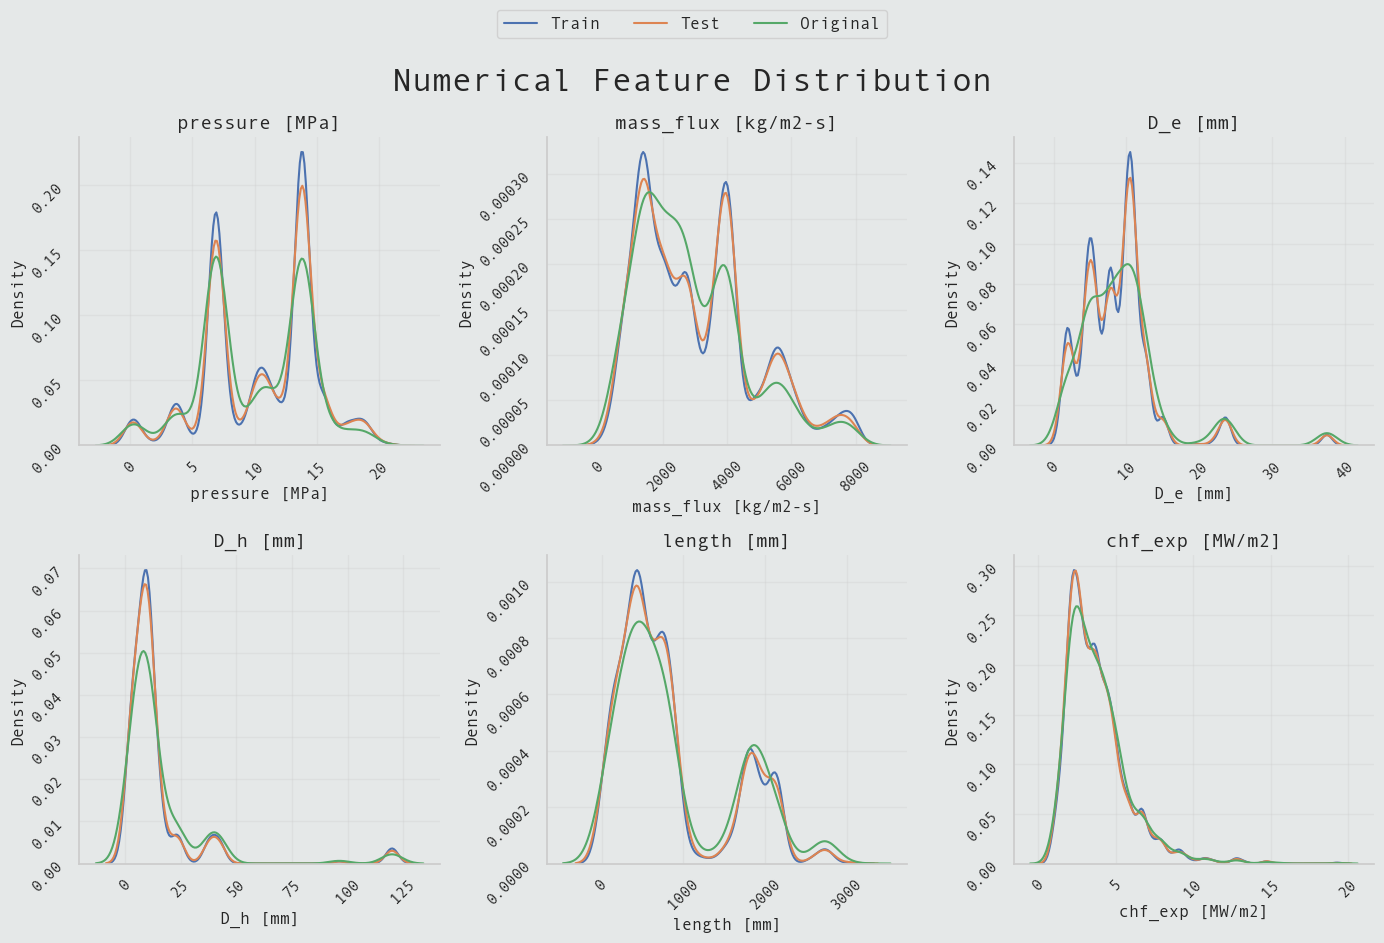

In [28]:
# Plot the KDE of each feature
figure, ax = plt.subplots(2, 3, figsize=(14, 9))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(raw_numerical_features):
    
    # Plot data
    sns.kdeplot(data=train_data[column_name],
                label='Train',
                ax=ax[index])
    
    sns.kdeplot(data=test_data[column_name],
                label='Test',
                ax=ax[index])
    
    sns.kdeplot(data=original_data[column_name],
                label='Original',
                ax=ax[index])
    
    # Set subplot title
    ax[index].set_title(column_name, fontsize=14)
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    
# Set the legend
figure.legend(handles, 
              labels, 
              loc='center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=3)

# Set figure Title
figure.suptitle('Numerical Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

- `D_h [mm]` and `chf_exp [MW/m2` are strongly right-skewed
- `length [mm]` follows a Binomial distribution
- Need to Standardise and Normalise the data

### Categorical Feature Distribution

#### Author Distribution

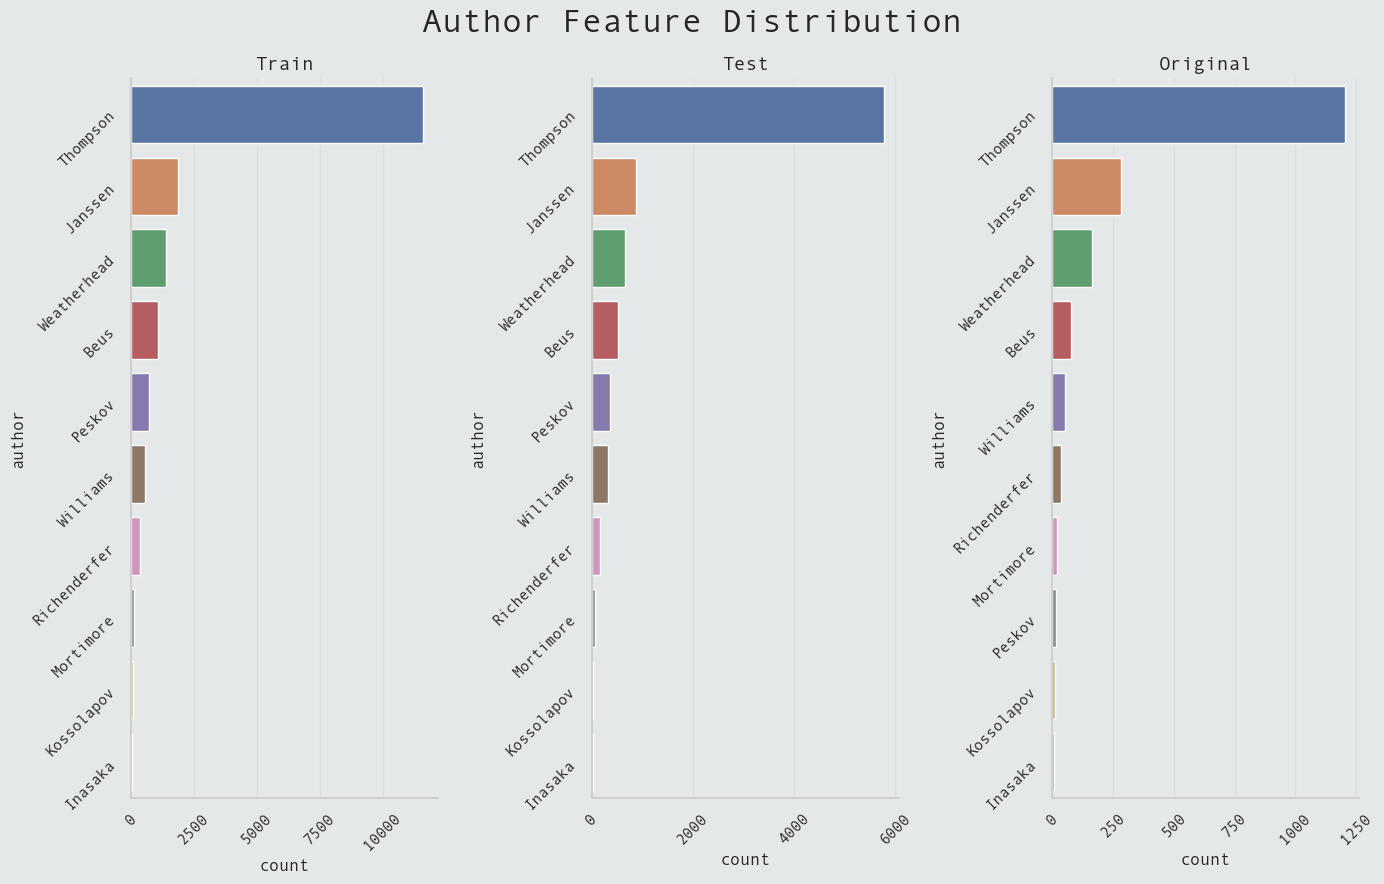

In [34]:
# Plot the countplot for the 'Author' feature
figure, ax = plt.subplots(1, 3, figsize=(14, 9))
ax = ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Plot data
    sns.countplot(data=data_to_plot[dataset_name],
                  y='author',
                  label=dataset_name,
                  order=data_to_plot[dataset_name]['author'].value_counts().index,
                  ax=ax[index])

    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
    # Set subplot title
    ax[index].set_title(f'{dataset_name}', 
                        fontsize=14)

# Set figure Title
figure.suptitle('Author Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

There's a huge imbalanced distribution in such a feature.

#### Geometry Distribution

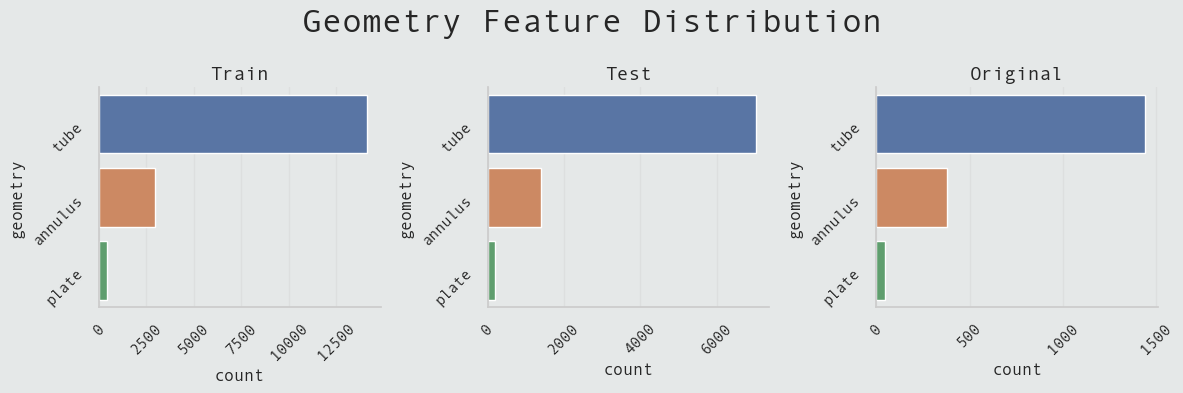

In [38]:
# Plot the countplot for the 'Geometry' feature
figure, ax = plt.subplots(3, 3, figsize=(12, 4))
ax = ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Plot data
    sns.countplot(data=data_to_plot[dataset_name],
                  y='geometry',
                  label=dataset_name,
                  order=data_to_plot[dataset_name]['geometry'].value_counts().index,
                  ax=ax[index])

    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
    # Set subplot title
    ax[index].set_title(f'{dataset_name}', 
                        fontsize=14)

# Set figure Title
figure.suptitle('Geometry Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

### Feature Distribution per Author

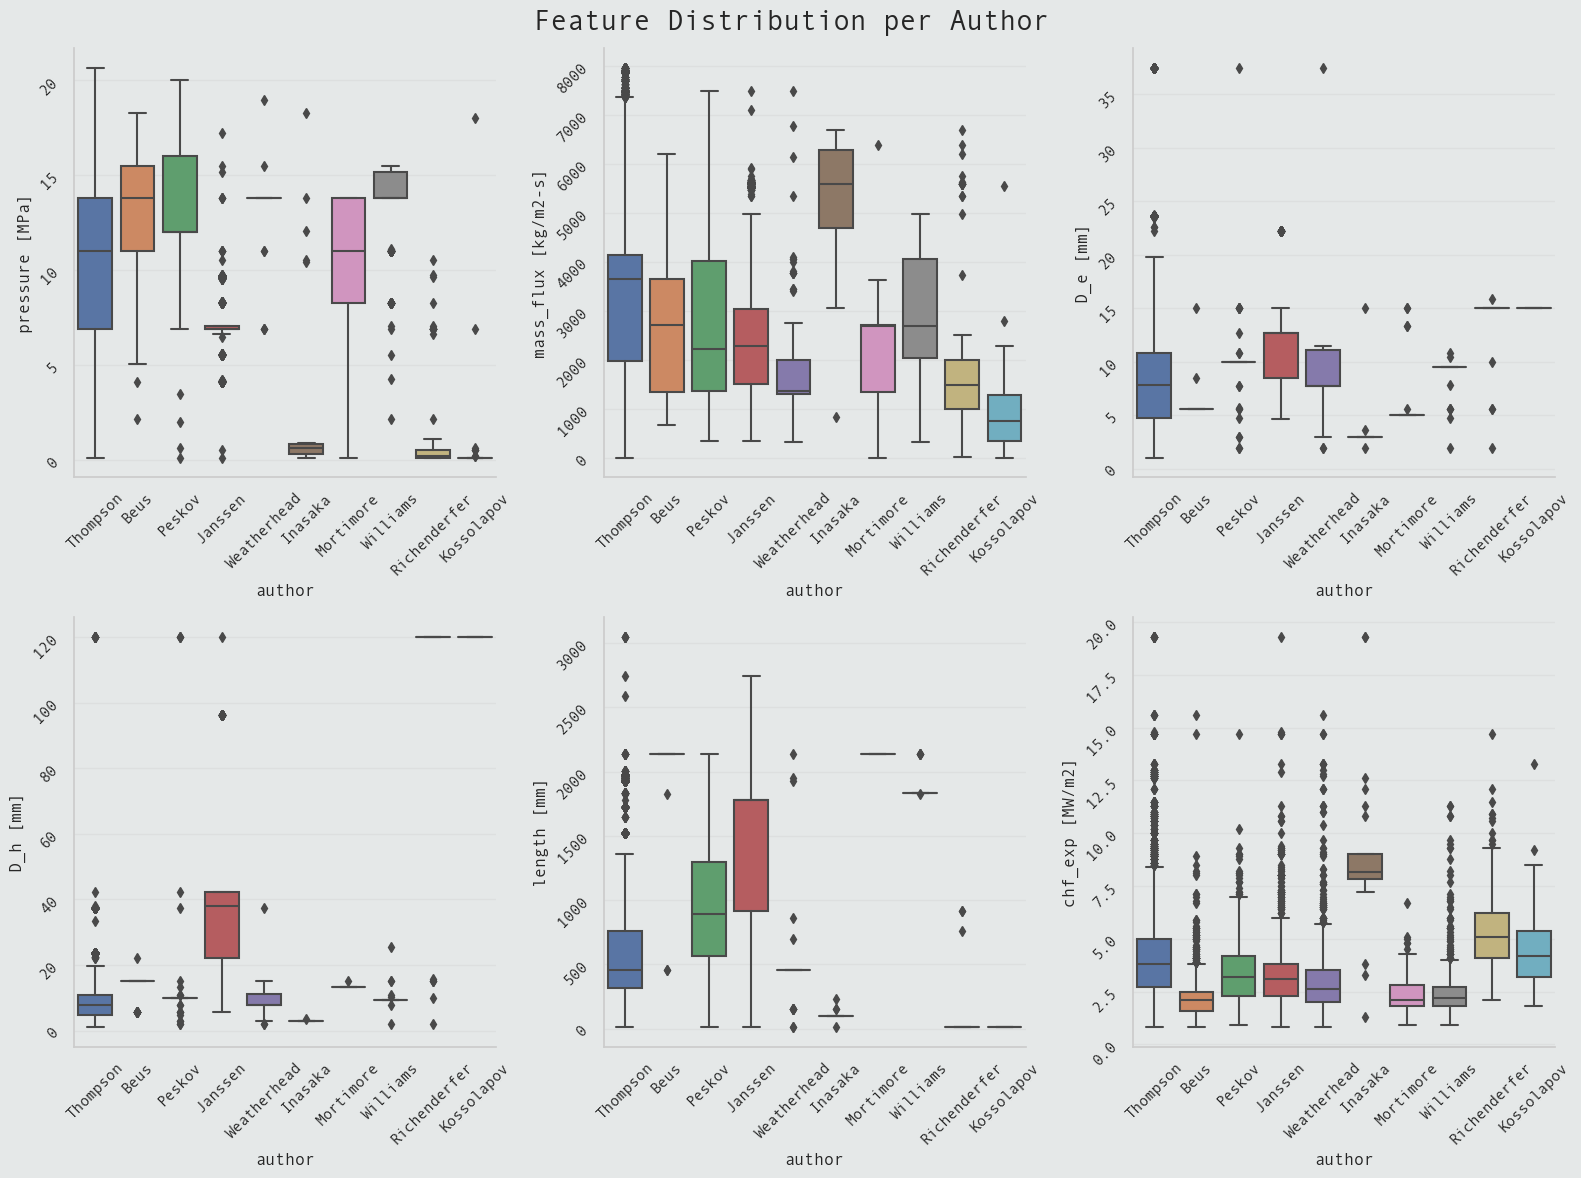

In [56]:
# Define figure and axes
figure, ax = plt.subplots(2, 3, figsize=(16, 12))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(train_data[raw_numerical_features]):
    
    # Plot data
    sns.boxplot(data=train_data,
                x='author',
                y=column_name,
                ax=ax[index])
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)

# Set figure Title
figure.suptitle('Feature Distribution per Author',
                fontweight='bold',
                fontsize=20)

plt.tight_layout()

There is no correlation between th `author` and the other features. Not include it in the feature list.

### Feature Distribution per Geometry

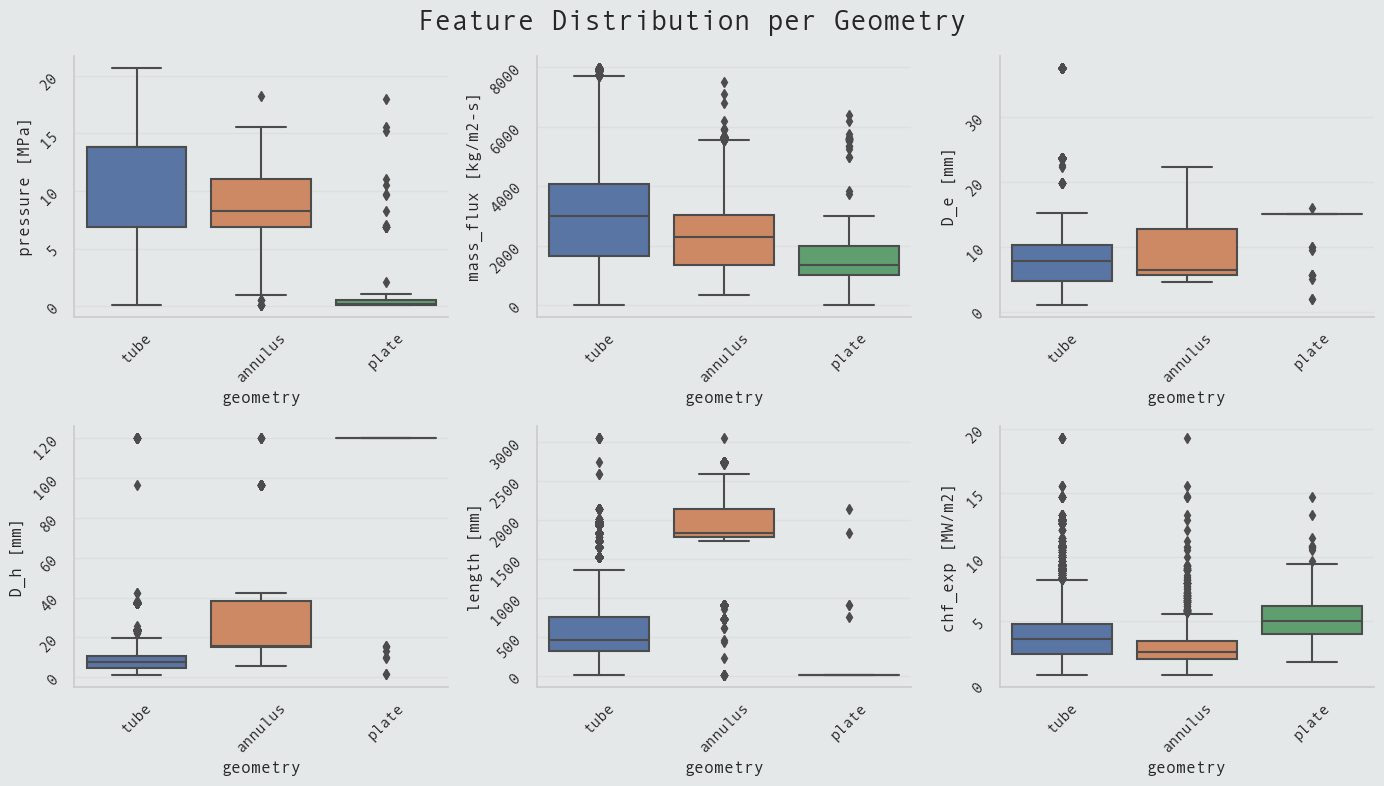

In [68]:
# Define figure and axes
figure, ax = plt.subplots(2, 3, figsize=(14, 8))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(train_data[raw_numerical_features]):
    
    # Plot data
    sns.boxplot(data=train_data,
                x='geometry',
                y=column_name,
                ax=ax[index])
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)

# Set figure Title
figure.suptitle('Feature Distribution per Geometry',
                fontweight='bold',
                fontsize=20)

plt.tight_layout()

Features are very different with respect to the geometry. It's important to include it as a feature

## Label Distribution

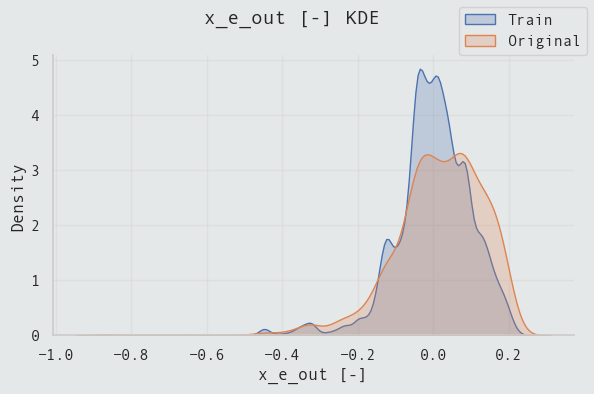

In [60]:
# Define figure and axes
figure, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot the KDE of label
sns.kdeplot(data=train_data['x_e_out [-]'], 
            fill=True,
            label='Train')

sns.kdeplot(data=original_data['x_e_out [-]'], 
            fill=True,
            label='Original')

# Set figure title
figure.suptitle('x_e_out [-] KDE', fontsize=14)

figure.legend()

plt.tight_layout()

They have the same distribution between Train and Original dataset.

## Pearson Correlation

In [43]:
# Define raw numerical features
correlation_raw_numerical_features = ['pressure [MPa]',
                                      'mass_flux [kg/m2-s]',
                                      'D_e [mm]', 
                                      'D_h [mm]', 
                                      'length [mm]', 
                                      'chf_exp [MW/m2]', 
                                      'x_e_out [-]']

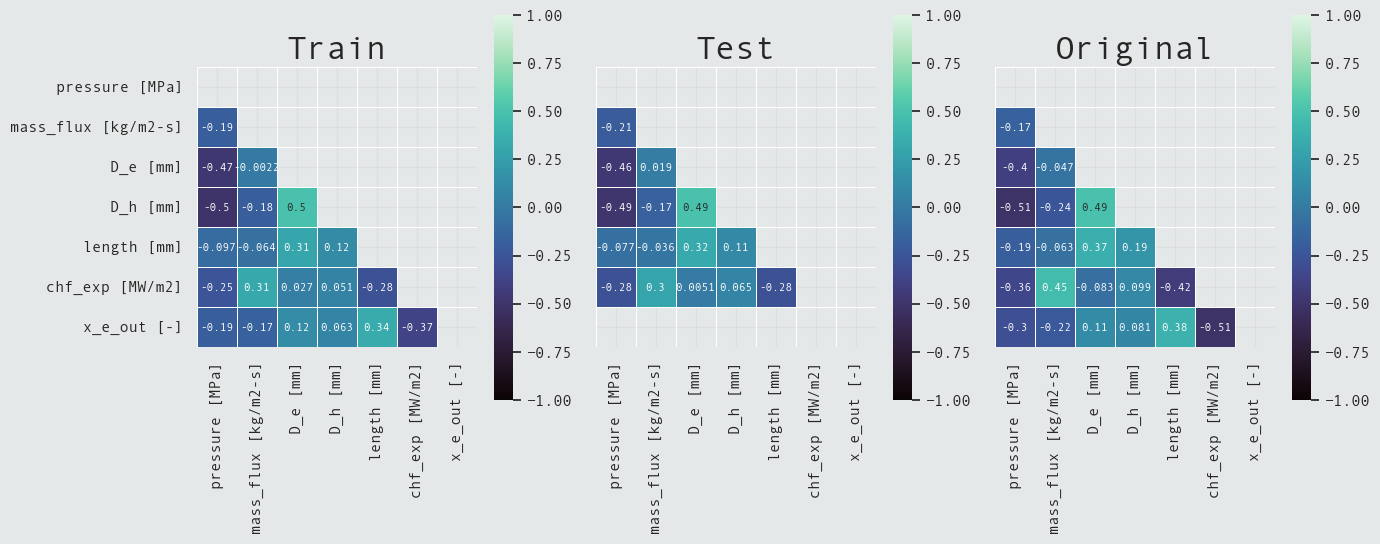

In [64]:
# Define figure and axis
figure, ax = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Compute the correlation matrix
    correlation_matrix = data_to_plot[dataset_name][correlation_raw_numerical_features].corr()
    
    # Generate a mask for the upper triangle
    correlation_mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Plot the correlation matrix
    sns.heatmap(correlation_matrix, 
                mask=correlation_mask, 
                cmap='mako',
                vmax=1.0, 
                vmin=-1.0, 
                center=0, 
                square=True, 
                linewidths=.5, 
                annot=True,
                annot_kws={'fontsize': 8},
                cbar_kws={"shrink":.8, 'orientation':'vertical'}, 
                ax=ax[index])

    # Set title
    ax[index].set_title(f'{dataset_name}',
                        fontweight='bold')


plt.tight_layout()

- Negative linear correlation between `D_e [mm]` and `pressure [MPa]`
- Negative linear correlation between `D_h [mm]` and `pressure [MPa]`
- Positive linear correlation between `D_h [mm]` and `D_e [mm]`

## Spearman Correlation

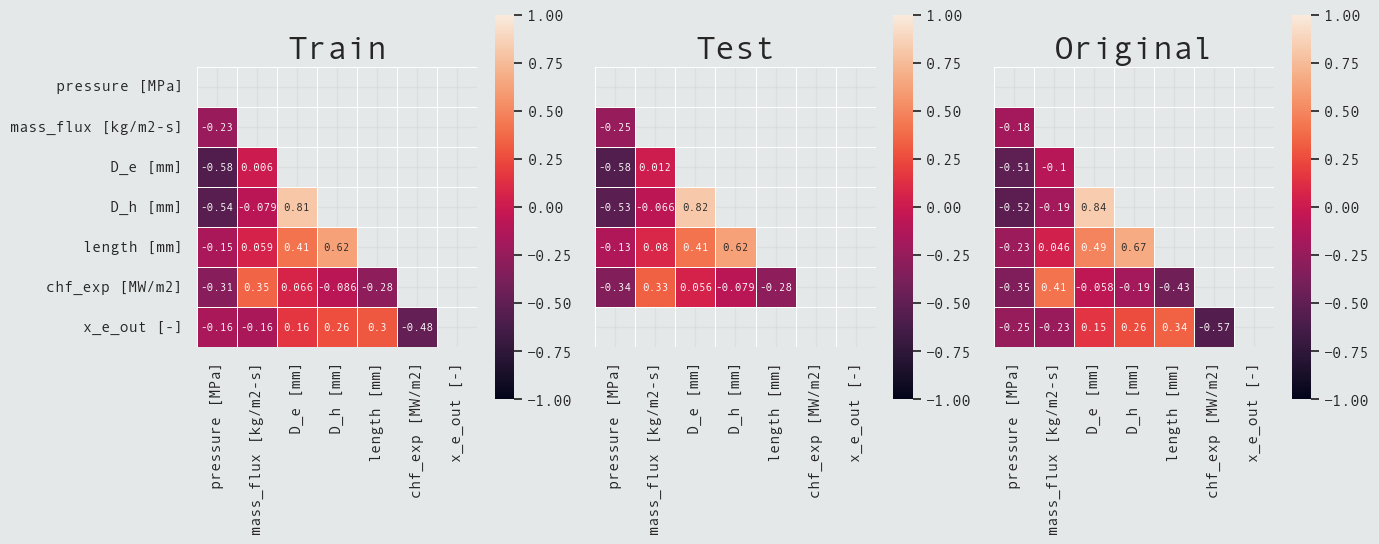

In [70]:
# Define figure and axis
figure, ax = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Compute the correlation matrix
    correlation_matrix = data_to_plot[dataset_name][correlation_raw_numerical_features].corr(method='spearman')
    
    # Generate a mask for the upper triangle
    correlation_mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Plot the correlation matrix
    sns.heatmap(correlation_matrix, 
                mask=correlation_mask, 
                cmap='rocket',
                vmax=1.0, 
                vmin=-1.0, 
                center=0, 
                square=True, 
                linewidths=.5, 
                annot=True,
                annot_kws={'fontsize': 8},
                cbar_kws={"shrink":.8, 'orientation':'vertical'}, 
                ax=ax[index])

    # Set title
    ax[index].set_title(f'{dataset_name}',
                        fontweight='bold')


plt.tight_layout()

- Positive non-linear correlation between `length [mm]` and `D_h [mm]`

## Conclusions 

- Impute null values
- Standardise numerical features
- Normalise numerical features (log transformation)
- One-hot Encoder for `geometry`
- Do not include `author`
- Negative linear correlation between `D_e [mm]` and `pressure [MPa]` > Create `D_e [mm] per pressure [MPa]`
- Negative linear correlation between `D_h [mm]` and `pressure [MPa]` > Create `D_h [mm] per pressure [MPa]`
- Positive linear correlation between `D_h [mm]` and `D_e [mm]` > Create `D_h [mm] per D_e [mm]`
- Positive non-linear correlation between `length [mm]` and `D_h [mm]` > Create `length [mm] per D_h [mm]`

# Data Preparation

## Feature Engineering

In [10]:
def compute_engineered_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    Create a pre-defined set of engineered feature to the input DataFrame
    
    Args:
        data Pandas.DataFrame input
    
    Returns:
        data Pandas.DataFrame with additional engineered features
    """
    
    # Create a feature `D_e [mm] per pressure [MPa]`
    data['D_e [mm] per pressure [MPa]'] = data['D_e [mm]'] / data['pressure [MPa]']
    
    return data

## Features and Label Definition

In [11]:
# Define features and labels
numerical_features = [
    'pressure [MPa]', 
    'mass_flux [kg/m2-s]', 
    'D_e [mm]', 
    'D_h [mm]', 
    'length [mm]', 
    'chf_exp [MW/m2]'
]

numerical_engineered_featuers = [
    #'D_e [mm] per pressure [MPa]'
]

categorical_features = [
    'geometry'
]

categorical_engineered_features = []

features = numerical_features + numerical_engineered_featuers + categorical_features + categorical_engineered_features

labels = ['x_e_out [-]']

## Define the Data Preprocessor Column Transformer

In [85]:
dummy_data_2 = pd.DataFrame({'col1': ['A', 'B', 'B', 'B', None], 
                             'col2': [1, 2, 3, None, 5]})

data_preprocessor_dummy = ColumnTransformer(
    transformers=[
        ('categorical', 
         Pipeline([
            ('imputer', SimpleImputer(missing_values=None, strategy='most_frequent', copy=False)),
            ('one_hot_encoder', OneHotEncoder())
         ]), ['col1']),
        ('numerical', SimpleImputer(), ['col2'])
    ])

result = pd.DataFrame(data_preprocessor_dummy.fit_transform(dummy_data_2), columns=data_preprocessor_dummy.get_feature_names_out())

result.head()

,categorical__col1_A,categorical__col1_B,numerical__col2
0,1.0,0.0,1.00
1,0.0,1.0,2.00
2,0.0,1.0,3.00
3,0.0,1.0,2.75
4,0.0,1.0,5.00
